# Homework 3

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1. Modeling Volatility and VaR

## Data

Find the data file `spy_data.xlsx`.

* Use the returns on the S&P 500 (`SPY`) and 1-month T-bills (`^IRX`).

* Calculate the excess market returns, using the treasury rate as the risk-free rate.

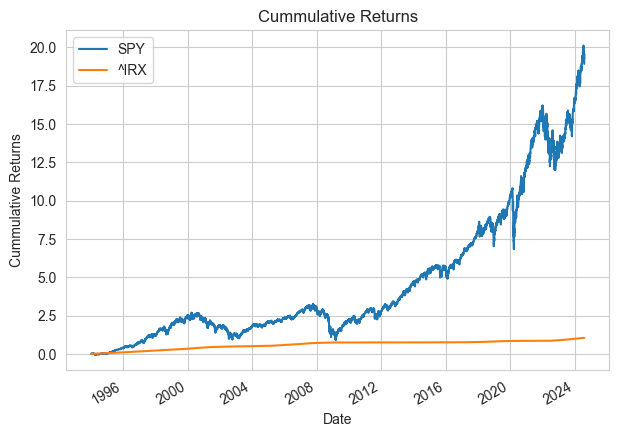

In [128]:
import pandas as pd
import numpy as np
import os
from arch import arch_model
import re
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
current_dir = os.getcwd()
import seaborn as sns
sns.set_style("whitegrid")
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))

PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

sys.path.insert(0, parent_dir)
sys.path.insert(0, grandparent_dir)
import cmds.portfolio_management_helper as pmh

spy_returns = pmh.read_excel_default("data/spy_data.xlsx", sheet_name=1)
spy_returns = spy_returns
pmh.calc_cummulative_returns(spy_returns)

In [129]:
spy_returns.tail(5)

,SPY,^IRX
date,,
2024-07-29,0.0006,0.0002
2024-07-30,-0.0051,0.0002
2024-07-31,0.0163,0.0002
2024-08-01,-0.0142,0.0002
2024-08-02,-0.0186,0.0002


In [130]:
spy_excess_returns = (
    spy_returns
    .assign(SPY=lambda df: df["SPY"] - df["^IRX"])
    .drop("^IRX", axis=1)
)
spy_excess_returns.tail(5)

,SPY
date,
2024-07-29,0.0004
2024-07-30,-0.0053
2024-07-31,0.0161
2024-08-01,-0.0144
2024-08-02,-0.0188


***

## 1.1 Historic VaR.
Starting at `Jan 2, 2001`, calculate the historic-based VaR, based on the expanding sample from the first date through `Dec 29, 2000`. 

Denote $\tilde{r}^{VaR, 0.05}_{t}$ as the estimate of the time-t VaR based on data through $t − 1$.

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* Plot $\tilde{r}^{VaR, 0.05}_{t}$ over time.

* Report the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$. Compare this to the quantile of $.05$.

* What drawbacks do you see in this historic VaR?

#### Note
By historic VaR, we mean simply taking the 5th quantile for the historic sample up to time $t − 1$. Of course, a sample size that is not a multiple of 100 will require some interpolation to get a 5th quantile. Your statistical package should handle this fine.

<span style="color:blue;">
We must shift the data because a VaR for a certain period accounts for every datapoint before that period.
</span>

In [131]:
spy_excess_returns_var = spy_excess_returns.copy()
spy_excess_returns_var["SPY Shifted"] = spy_excess_returns_var["SPY"].shift(1)
spy_excess_returns_var

,SPY,SPY Shifted
date,,
1994-01-04,0.0039,NaN
1994-01-05,0.0019,0.0039
1994-01-06,-0.0001,0.0019
1994-01-07,0.0059,-0.0001
1994-01-10,0.0118,0.0059
...,...,...
2024-07-29,0.0004,0.0110
2024-07-30,-0.0053,0.0004
2024-07-31,0.0161,-0.0053


<span style="color:blue;">
Because we are calculating with the expanding window, all datapoints before the period of the VaR will be used.

In this case, we define that the expanding window starts being calculated at the 60th observation. Before that, the function generates NAs. Choosing another number of `min_period` would not make a difference in this case since we should filter after to only account for returns after 2001-01-01.
</span>

In [132]:
spy_excess_returns_var["SPY Historical VaR 5%"] = (
    spy_excess_returns_var["SPY Shifted"].expanding(min_periods=60).quantile(.05)
)
spy_excess_returns_var = spy_excess_returns_var.loc["2001-01-01":]
spy_excess_returns_var

,SPY,SPY Shifted,SPY Historical VaR 5%
date,,,
2001-01-02,-0.0183,-0.0192,-0.0177
2001-01-03,0.0478,-0.0183,-0.0178
2001-01-04,-0.0110,0.0478,-0.0178
2001-01-05,-0.0328,-0.0110,-0.0178
2001-01-08,0.0075,-0.0328,-0.0179
...,...,...,...
2024-07-29,0.0004,0.0110,-0.0185
2024-07-30,-0.0053,0.0004,-0.0185
2024-07-31,0.0161,-0.0053,-0.0185


<span style="color:blue;">
Again, the VaR for a certain period includes data up until the period before.

For instance, when we get the VaR for "2001-03-28", we use data until "2001-03-27".
</span>

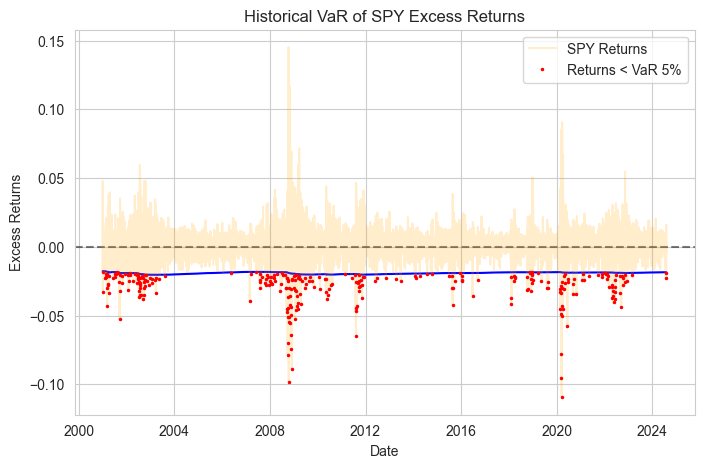

In [133]:
plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var["SPY Historical VaR 5%"].dropna(),
    color=COLORS[0]
)
spy_excess_returns_surpass_var = (
    spy_excess_returns_var
    .dropna()
    .loc[lambda df: df["SPY"] < df["SPY Historical VaR 5%"]]
)
plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var.dropna()["SPY"],
    color=COLORS[2],
    label="SPY Returns",
    alpha=.2
)
plt.plot(
    spy_excess_returns_surpass_var.index,
    spy_excess_returns_surpass_var["SPY"],
    linestyle="",
    marker="o",
    color=COLORS[1],
    label="Returns < VaR 5%",
    markersize=1.5
)
plt.title("Historical VaR of SPY Excess Returns")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.show()

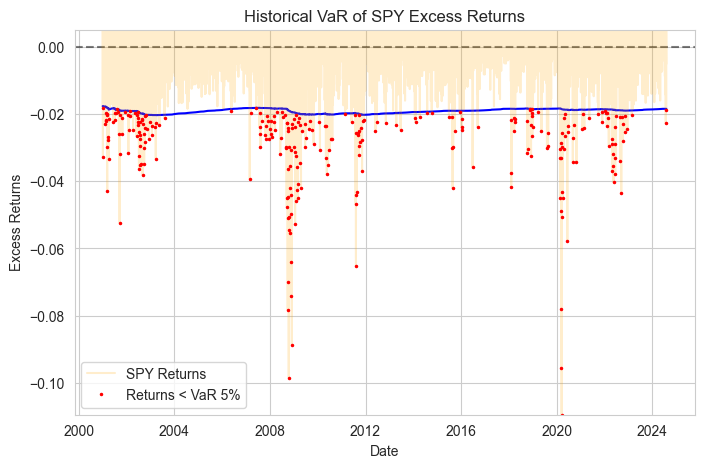

In [134]:
plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var["SPY Historical VaR 5%"].dropna(),
    color=COLORS[0]
)
spy_excess_returns_surpass_var = (
    spy_excess_returns_var
    .dropna()
    .loc[lambda df: df["SPY"] < df["SPY Historical VaR 5%"]]
)
plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var.dropna()["SPY"],
    color=COLORS[2],
    label="SPY Returns",
    alpha=.2
)
plt.plot(
    spy_excess_returns_surpass_var.index,
    spy_excess_returns_surpass_var["SPY"],
    linestyle="",
    marker="o",
    color=COLORS[1],
    label="Returns < VaR 5%",
    markersize=1.5
)
plt.ylim(min(spy_excess_returns_var["SPY"]), .005)
plt.title("Historical VaR of SPY Excess Returns")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.show()

<span style="color:blue;">
Each of the dots is a time in which the return was below the VaR thershold.
</span>

In [135]:
spy_excess_returns_var_analysis = (
    spy_excess_returns_var
    .dropna()
    .assign(smaller=lambda df: df["SPY"] < df["SPY Historical VaR 5%"])
    .rename({"smaller": "Return < VaR 5%"}, axis=1)
)
spy_excess_returns_var_analysis

,SPY,SPY Shifted,SPY Historical VaR 5%,Return < VaR 5%
date,,,,
2001-01-02,-0.0183,-0.0192,-0.0177,True
2001-01-03,0.0478,-0.0183,-0.0178,False
2001-01-04,-0.0110,0.0478,-0.0178,False
2001-01-05,-0.0328,-0.0110,-0.0178,True
2001-01-08,0.0075,-0.0328,-0.0179,False
...,...,...,...,...
2024-07-29,0.0004,0.0110,-0.0185,False
2024-07-30,-0.0053,0.0004,-0.0185,False
2024-07-31,0.0161,-0.0053,-0.0185,False


In [136]:
spy_excess_returns_var_count = (
    spy_excess_returns_var_analysis
    .groupby("Return < VaR 5%")
    ["Return < VaR 5%"]
    .agg(["count"])
    .assign(percentage=lambda df: df['count'] / df['count'].sum(axis=0))
    .rename(columns=lambda c: c.title())
)
spy_excess_returns_var_count

,Count,Percentage
Return < VaR 5%,,
False,5639,0.9514
True,288,0.0486


<span style="color:blue;">

The frequency of returns below the VaR threshold is 4.86%.

</span>

In [137]:
hit_ratio = spy_excess_returns_var_count.loc[True, 'Percentage']
hit_ratio_error = abs(hit_ratio / .05 - 1)
print(f"Hit Ratio: {hit_ratio:.2%}; Hit Ratio Error: {hit_ratio_error:.2%}")

Hit Ratio: 4.86%; Hit Ratio Error: 2.82%


<span style="color:blue;">

How good is my VaR?

Resonable... but it overestimates the tail risk of my asset/portfolio. We define how good our estimate is based on the hit ratio (frequency of returns below the threshold).

#### Hit Ratio

$$
\text{Hit Ratio} = \frac{n (\\ R_t < \text{VaR}(q)_t)}{n}
$$

#### Hit Ratio Error

$$
\text{Hit Ratio Error} = \left| \frac{\text{Hit Ratio}}{q} - 1 \right|
$$

$q$ is always your target Hit Ratio. If your $Hit Ratio < q$, your VaR estimate is overestimating risk. If you $Hit Ratio > q$ your VaR estimate is underestimating the risk.

#### Our goal
Find a VaR estimate which in the out-of-sample has the smallest hit ratio error.

</span>

<span style="color:blue;">

#### What drawbacks do you see in this historic VaR?

Empirical estimation lacks statistical power compared to parametric estimation. When using empirical VaR, only a small sample portion is used to estimate the VaR for the desired quantile. Parametric approaches use the whole sample to calculate volatility, then estimate VaR.

This difference is more significant when we adjust the VaR period based on market changes. For example, if we focus on the last 20 days instead of five years, empirical VaR may rely on a single data point. In contrast, parametric methods estimate volatility over the 20 days, offering more statistically robust results.

Thus, while parametric methods may introduce bias (e.g., assuming normality), they provide better precision, particularly for small samples.

Calculating VaR with a normal distribution is also easier.

Generally, parametric VaR outperforms empirical VaR.

The same holds for CVaR: parametric CVaR provides more statistical significance than its empirical counterpart.
</span>


<span style="color:blue;">

#### What changes in other VaR estimates?

The way (the function) I define the VaR for each period.

The way to define the VaR with the expanding window is basically a function that takes a vector and returns a vector:

```python
def expanding_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.expanding(min_periods=60).quantile(percentile)
```

I get the historical rolling VaR by changing this function:

```python
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=60).quantile(percentile)
```
</span>


<span style="color:blue;">

## Extra
We can change the function which calculate VaR to check how other methodologies perform.

#### Rolling VaR

Given a rolling 60 period window size $r$:

$$
\text{VaR}(q)_t = p^q \left[ r_{t-r}, \\ r_{t-(r-1)}, \\ r_{t-(r-2)}, \\ \dots, \\ r_{t-1}\right]_{60 \times 1}
$$

On the other hand, expanding VaR would use the entire sample up to that point:

$$
\text{VaR}(q)_t = p^q \left[ r_1, \\ r_2, \\ r_3, \\ \dots, \\ r_{t-1}\right]_{t \times 1}
$$


#### Rolling compared to Expanding
- Does not consider considerably old data which might be prior to a structural change.
- Has a hard threshold of which data is important and which is not important to calculate the VaR: using rolling window, datapoints extremely sensitive in the VaR calculation are removed from the calculation once they become old enough (before the rolling start).

</span>

In [138]:
def var_calculator(excess_returns, var_func, var_name, percentile, limit = True):
    excess_returns = excess_returns.copy()
    excess_returns["SPY Shifted"] = excess_returns["SPY"].shift()
    excess_returns[var_name] = var_func(excess_returns["SPY Shifted"], percentile)
    excess_returns = excess_returns.dropna(axis=0)
    excess_returns = excess_returns.loc["2001-01-01":]

    plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    plt.plot(
        excess_returns.dropna().index,
        excess_returns[var_name].dropna(),
        color=COLORS[0],
        label=var_name
    )
    plt.plot(
        excess_returns.dropna().index,
        excess_returns["SPY"].dropna(),
        color=COLORS[2],
        label="SPY Returns",
        alpha=.2
    )
    excess_returns_surpass_var = (
        excess_returns
        .dropna()
        .loc[lambda df: df["SPY"] < df[var_name]]
    )
    plt.plot(
        excess_returns_surpass_var.index,
        excess_returns_surpass_var["SPY"],
        linestyle="",
        marker="o",
        color=COLORS[1],
        label=f"Return < {var_name}",
        markersize=1.5
    )
    if limit:
        plt.ylim(min(excess_returns["SPY"]), .01)
    hit_ratio = len(excess_returns_surpass_var.index) / len(excess_returns.index)
    hit_ratio_error = abs((hit_ratio / percentile) - 1)
    plt.title(f"{var_name} of SPY Excess Returns")
    plt.xlabel(
        f"Hit Ratio: {hit_ratio:.2%}; Hit Ratio Error: {hit_ratio_error:.2%}"
    )
    plt.ylabel("Excess Returns")
    plt.legend()
    plt.show()

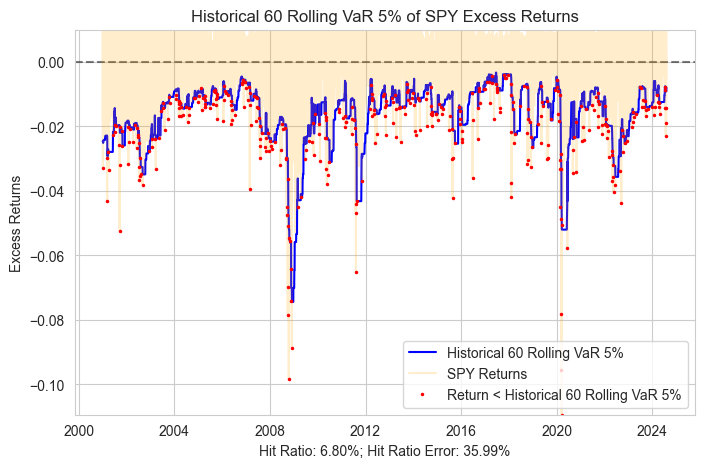

In [139]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=60).quantile(percentile)

var_calculator(
    spy_excess_returns, historical_rolling_var, "Historical 60 Rolling VaR 5%", .05
)

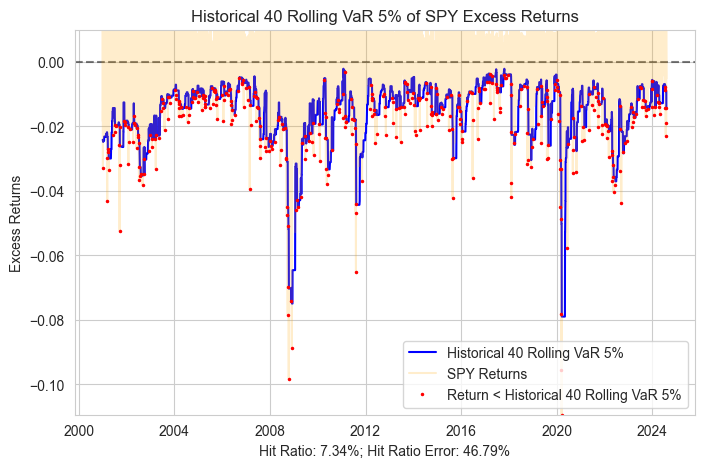

In [140]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=40).quantile(percentile)

var_calculator(
    spy_excess_returns, historical_rolling_var, "Historical 40 Rolling VaR 5%", .05
)

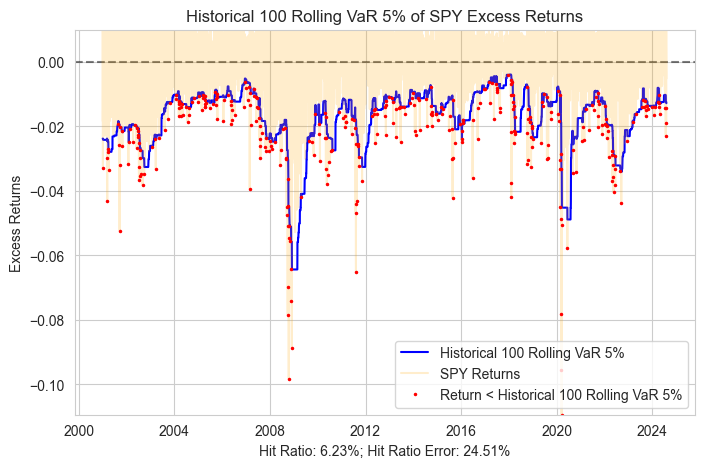

In [141]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=100).quantile(percentile)

var_calculator(
    spy_excess_returns, historical_rolling_var, "Historical 100 Rolling VaR 5%", .05
)

VaR and CVaR are given shifted by 1.000000 period(s).
VaR and CVaR are given shifted by 1.000000 period(s).


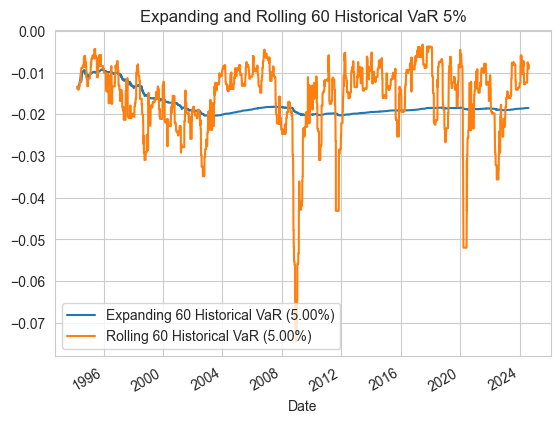

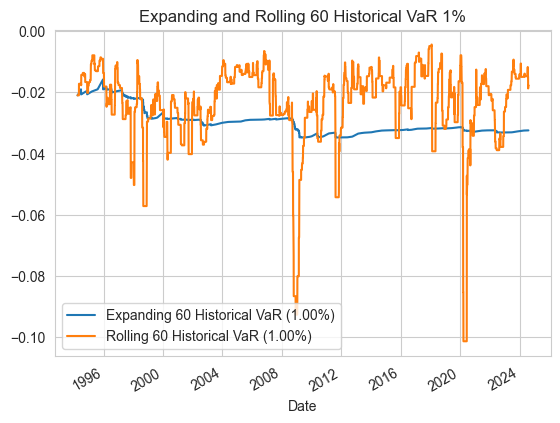

In [142]:
(
    pmh.calc_var_cvar_summary(
        spy_excess_returns,
        keep_columns=["Expanding 60 Historical VaR", "Rolling 60 Historical VaR"],
        window=60,
        shift=1,
        z_score=-1.65
    )
    .dropna()
    .plot(title="Expanding and Rolling 60 Historical VaR 5%", xlabel="Date")
)
(
    pmh.calc_var_cvar_summary(
        spy_excess_returns,
        keep_columns=["Expanding 60 Historical VaR", "Rolling 60 Historical VaR"],
        window=60,
        shift=1,
        quantile=.01,
    )
    .dropna()
    .plot(title="Expanding and Rolling 60 Historical VaR 1%", xlabel="Date")
);

## 1.2 Volatility
We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-t return volatility.

#### Expanding Series

$$
\sigma^2_{t,expanding} = \frac{1}{t-1}\sum_{\tau = 1}^{t-1}\tilde{r}^2_{\tau}
$$

#### Rolling Window

$$
\sigma^2_{t,rolling} = \frac{1}{m}\sum_{l = 1}^{m}\tilde{r}^2_{t-l}
$$

Use $m=$`252`.


#### Exponentially Weighted Moving Average (EWMA)

Feel free to calculate the EWMA using the following recursion,
$$
\sigma^2_{t, EWMA} = \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1}
$$

Rather than estimating $\theta$, simply use $\theta$ = 0.94, and initialize with 
$$\sigma_{t_0} = \frac{0.20}{\sqrt{252}}$$

### Report
Report the items below, starting at , starting at `Jan 2, 2001`.

* For each of these three methods, plot $\sigma_t$. (Plot the vol, not the variance.)

* For each method, calculate the 5th percentile, 1-day-ahead VaR. We use a slight simplification of the normal VaR formula, by dropping $\mu$ from that formula, and rounding the normal distribution z-score to -1.65.
$$\tilde{r}^{VaR, 0.05}_{t} = −1.65 \sigma_t$$

* For each of these vol-based VaR estimates, calculate the frequency of periods in which $\tilde{r} < \tilde{r}^{VaR, 0.05}_{t}$

* Compare and contrast your results among each other and relative to the historic method in the previous problem.

<span style="color:blue;">

#### Expanding

We consider that the series of returns has mean 0, which leads to a different formula for the "std".

</span>

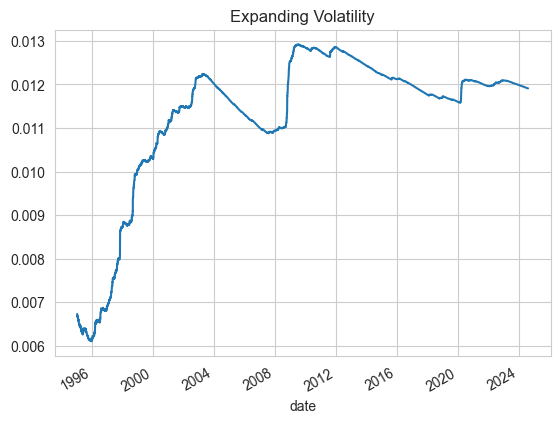

In [143]:
def expanding_vol(return_series: pd.Series) -> pd.Series:
    return np.sqrt((return_series ** 2).expanding(252).mean())

expanding_vol(spy_excess_returns["SPY"].shift(1)).plot(title="Expanding Volatility");

<span style="color:blue;">

#### Rolling

Again, we consider that the series of returns has mean 0, which leads to a different formula for the "std".

</span>

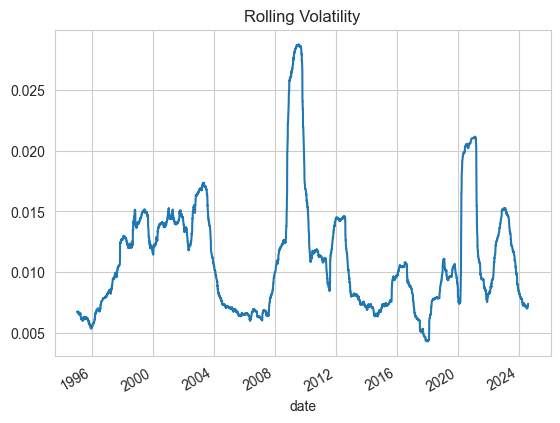

In [144]:
def rolling_vol(return_series: pd.Series) -> pd.Series:
    return np.sqrt((return_series ** 2).rolling(252).mean())

rolling_vol(spy_excess_returns["SPY"].shift(1)).plot(title="Rolling Volatility");

<span style="color:blue;">

#### EWMA
Again, we consider that the series of returns has mean 0, which leads to a different formula for the "std".

The main advantages of using EWMA when compared to rolling or expanding is that:
- we do not have to set a hard threshold for values that should be considered in our estimate and values which shouldn't.
- the estimate gives more importance to newer observations.

</span>

In [145]:
def calc_ewma_volatility(excess_returns: pd.Series, theta : float = 0.94, initial_vol : float = .2 / np.sqrt(252)) -> pd.Series:
    var_t0 = initial_vol ** 2
    ewma_var = [var_t0]
    for i in range(len(excess_returns.index)):
        new_ewma_var = ewma_var[-1] * theta + (excess_returns.iloc[i] ** 2) * (1 - theta)
        ewma_var.append(new_ewma_var)
    ewma_var.pop(0) # Remove var_t0
    ewma_vol = [np.sqrt(v) for v in ewma_var]
    return pd.Series(ewma_vol, index=excess_returns.index)

<Axes: title={'center': 'EWMA Volatility'}, xlabel='Date'>

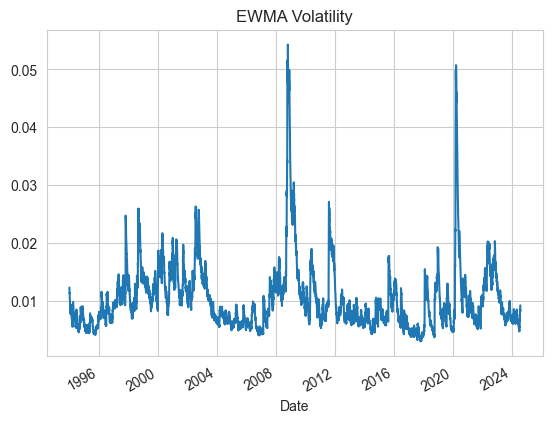

In [146]:
calc_ewma_volatility(spy_excess_returns["SPY"].shift().dropna()).plot(title="EWMA Volatility", xlabel="Date")

<Axes: title={'center': 'EWMA Volatility for Different Theta'}, xlabel='date'>

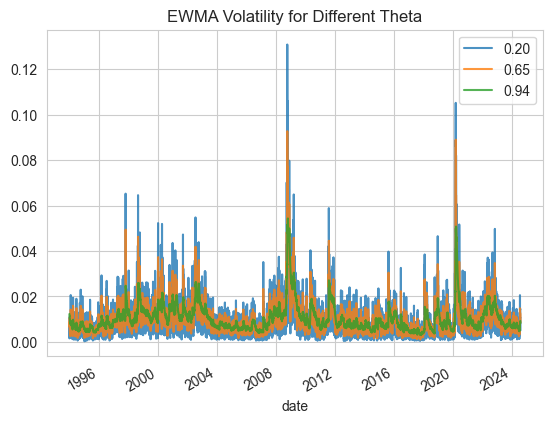

In [147]:
(
    pd.concat([
        calc_ewma_volatility(spy_excess_returns["SPY"].shift().dropna(), theta=.20).to_frame("0.20"),
        calc_ewma_volatility(spy_excess_returns["SPY"].shift().dropna(), theta=.65).to_frame("0.65"),
        calc_ewma_volatility(spy_excess_returns["SPY"].shift().dropna(), theta=.94).to_frame("0.94"),
    ], axis=1)
    .plot(title="EWMA Volatility for Different Theta", alpha=.8)
)

<span style="color:blue;">

#### What is the importance of previous returns?

\begin{align*}
\sigma^2_{t, EWMA} &= \theta \sigma^2_{t-1, EWMA} + (1-\theta)\tilde{r}^2_{t-1} \\
                   &= \theta (\theta \sigma^2_{t-2, EWMA} + (1-\theta)\tilde{r}^2_{t-2}) + (1-\theta)\tilde{r}^2_{t-1} \\
                   &= \theta (\theta (\theta \sigma^2_{t-3, EWMA} + (1-\theta)\tilde{r}^2_{t-3}) + (1-\theta)\tilde{r}^2_{t-2}) + (1-\theta)\tilde{r}^2_{t-1} \\
                   &= \dots
\end{align*}

For instance, in $\sigma^2_{t, EWMA}$ the importance of the return of $t-3$ is:

$$
\theta^2 (1-\theta)\tilde{r}^2_{t-3}
$$

For a generic $t-k$ return in $\sigma^2_{t, EWMA}$

$$
\theta^{(k-1)} (1-\theta)\tilde{r}^2_{t-k}
$$

For larger $\theta$'s the importance of returns is more homogeneous. For smaller $\theta$'s, the importance is concentrated in smaller lags (more recent periods).

</span>

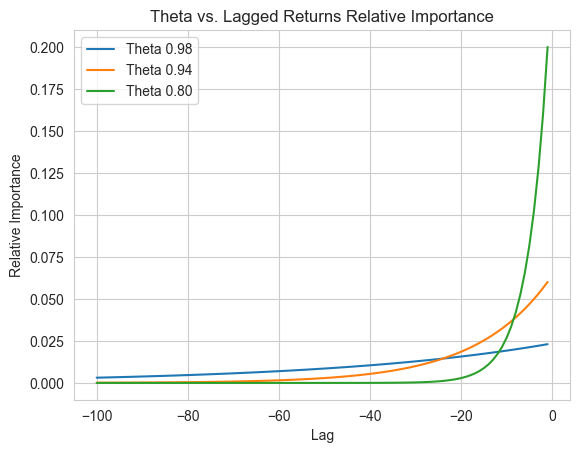

In [148]:
THETAS = [.98, .94, .8]

(
    pd.DataFrame(index=list(range(-100, 0)))
    .assign(
        **{f"Theta {t:.2f}": (lambda t=t: lambda df: (t ** (abs(df.index)-1)) * (1 - t))() for t in THETAS},
    )
    .apply(lambda df: df / df.sum(axis=0))
    .plot(title="Theta vs. Lagged Returns Relative Importance", xlabel="Lag", ylabel="Relative Importance")
);

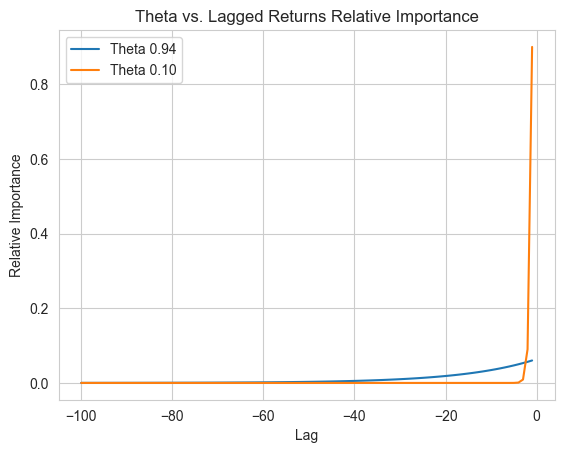

In [149]:
THETAS = [.94, .1]

(
    pd.DataFrame(index=list(range(-100, 0)))
    .assign(
        **{f"Theta {t:.2f}": (lambda t=t: lambda df: (t ** (abs(df.index)-1)) * (1 - t))() for t in THETAS},
    )
    .apply(lambda df: df / df.sum(axis=0))
    .plot(title="Theta vs. Lagged Returns Relative Importance", xlabel="Lag", ylabel="Relative Importance")
);

VaR and CVaR are given shifted by 1.000000 period(s).


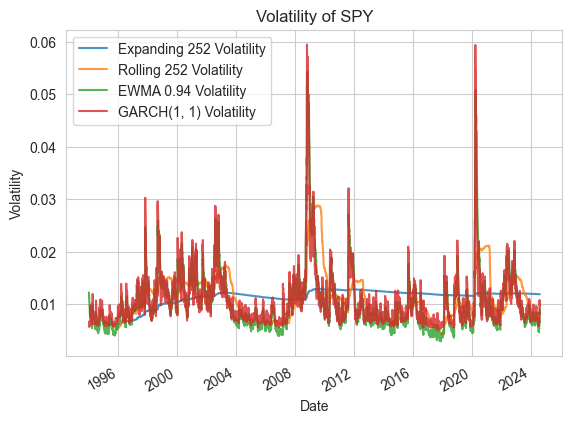

In [150]:
spy_volatility = pmh.calc_var_cvar_summary(
    spy_excess_returns,
    window=252,
    quantile=.05,
    ewma_theta=.94,
    ewma_initial_vol=.2/np.sqrt(252),
    z_score=-1.65,
    keep_columns=["Volatility"]
)
spy_volatility.plot(title="Volatility of SPY", xlabel="Date", ylabel="Volatility", alpha=.8);

<span style="color:blue;">

A bigger $\theta$ leads to EWMA more similar to rolling variance.

</span>

VaR and CVaR are given shifted by 1.000000 period(s).


<Axes: title={'center': 'Volatility of SPY (Alternative EMWA Theta)'}, xlabel='Date', ylabel='Volatility'>

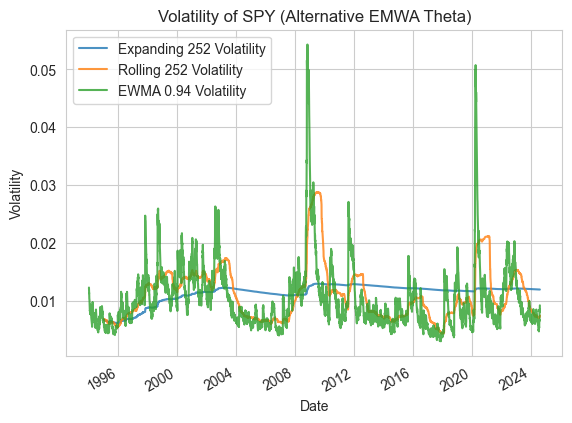

In [151]:
spy_volatility = pmh.calc_var_cvar_summary(
    spy_excess_returns,
    window=252,
    quantile=.05,
    ewma_theta=.94,
    ewma_initial_vol=.2/np.sqrt(252),
    z_score=-1.65,
    keep_columns=["Volatility"],
    drop_columns=["GARCH"]
)
spy_volatility.plot(title="Volatility of SPY (Alternative EMWA Theta)", xlabel="Date", ylabel="Volatility", alpha=.8)

In [152]:
spy_parametric_var = pmh.calc_var_cvar_summary(
    spy_excess_returns,
    window=252,
    quantile=.05,
    ewma_theta=.94,
    ewma_initial_vol=.2/np.sqrt(252),
    z_score=-1.65,
    keep_columns=["Expanding 252 Parametric VaR", "Rolling 252 Parametric VaR", "EWMA 0.94 Parametric VaR"]
)
spy_parametric_var.tail(3)

VaR and CVaR are given shifted by 1.000000 period(s).


,Expanding 252 Parametric VaR (5.00%),Rolling 252 Parametric VaR (5.00%),EWMA 0.94 Parametric VaR (5.00%)
date,,,
2024-07-31,-0.0197,-0.0120,-0.0133
2024-08-01,-0.0197,-0.0121,-0.0144
2024-08-02,-0.0197,-0.0122,-0.0151


<Axes: title={'center': 'Parametric VaR'}, xlabel='Date', ylabel='Returns'>

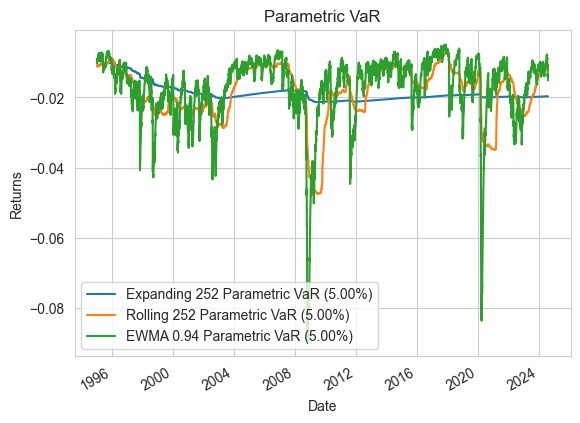

In [153]:
(
    spy_parametric_var
    .dropna()
    .plot(title="Parametric VaR", xlabel="Date", ylabel="Returns")
)

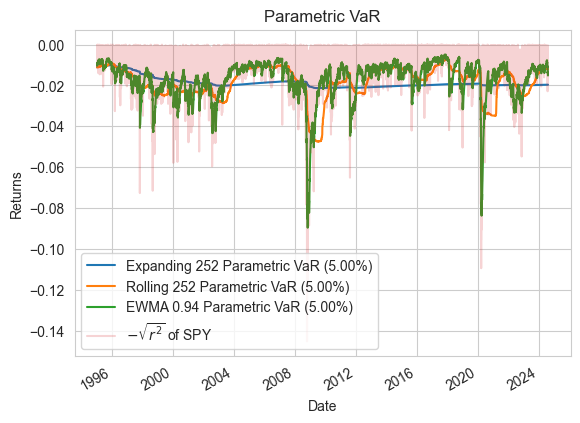

In [154]:
(
    spy_parametric_var
    .dropna()
    .plot(title="Parametric VaR", xlabel="Date", ylabel="Returns")
)
plt.plot(
    spy_parametric_var
    .dropna()
    .join(spy_excess_returns.apply(lambda df: - np.sqrt(df ** 2)))
    .loc[:, ["SPY"]],
    alpha=.2,
    label="$-\sqrt{r^2}$ of SPY"
)
plt.legend()
plt.show();

<span style="color:blue;">

EWMA has the advantage of considering "volatility clusters". In contrast with the first moment, volatility is predictable. Days with high volatility are generally followed by other days with high volatility. This feature is more easily captured by EWMA (or GARCH).


#### Hit Ratio
For this sample, the best hit ratio was provided by Expanding Historical VaR and Rolling 252 Parametric VaR.

The expanding windows overestimated the risk. The error is possibly a consequence of volatility during one of the used periods reduction in SPY.
</span>

In [155]:
pmh.calc_var_cvar_summary(
    spy_excess_returns,
    window=252,
    quantile=.05,
    ewma_theta=.94,
    ewma_initial_vol=.2/np.sqrt(252),
    filter_first_hit_ratio_date="2001-01-01",
    z_score=-1.65,
    return_hit_ratio=True,
    shift=1,
    drop_indexes=["GARCH"]
)

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
Expanding 252 Historical VaR (5.00%),0.0486,-0.0282,0.0282
Rolling 252 Parametric VaR (5.00%),0.0528,0.0562,0.0562
Rolling 252 Historical VaR (5.00%),0.0530,0.0596,0.0596
Expanding 252 Parametric VaR (5.00%),0.0461,-0.0788,0.0788
EWMA 0.94 Parametric VaR (5.00%),0.0599,0.1979,0.1979


In [156]:
pmh.calc_summary_statistics(
    spy_excess_returns,
    timeframes={
        "2000-2003": ["2000", "2003"],
        "2004-2008": ["2004", "2008"],
        "2009-2012": ["2009", "2012"],
        "2013-2017": ["2013", "2017"],
        "2018-2022": ["2018", "2022"],
    },
    keep_columns=["Annualized Vol", "Annualized Historical VaR"],
    annual_factor=252,
    provided_excess_returns=True
)

,Annualized Vol,Annualized Historical VaR (5.00%)
SPY 2000-2003,0.2255,-0.3622
SPY 2004-2008,0.2145,-0.2745
SPY 2009-2012,0.2075,-0.3498
SPY 2013-2017,0.1186,-0.2007
SPY 2018-2022,0.2154,-0.3376


***

## 1.3 CVaR
Re-do the previous two problems, but this time calculating CVaR instead of VaR, (still for $q =$ `.05`.)

<span style="color:blue;">

#### Historical CVaR

Historical CVaR refers to the average of returns below the Historical VaR.

Changing the VaR function from:

```python
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(252).quantile(percentile)
```

```python
def historical_expanding_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.expanding(252).quantile(percentile)
```

to:

</span>

In [157]:
def historical_expanding_cvar(return_series: pd.Series, percentile: float = .05) -> pd.Series:
    return return_series.expanding(252).apply(lambda x: x[x < x.quantile(percentile)].mean())

def historical_rolling_cvar(return_series: pd.Series, percentile: float = .05) -> pd.Series:
    return return_series.rolling(252).apply(lambda x: x[x < x.quantile(percentile)].mean())

spy_cvar_example = pd.concat([
    historical_expanding_cvar(spy_excess_returns["SPY"].shift()).to_frame("Expanding CVaR"),
    historical_rolling_cvar(spy_excess_returns["SPY"].shift()).to_frame("Rolling CVaR")
], axis=1)
spy_cvar_example.tail(5)

,Expanding CVaR,Rolling CVaR
date,,
2024-07-29,-0.0284,-0.0154
2024-07-30,-0.0284,-0.0154
2024-07-31,-0.0284,-0.0154
2024-08-01,-0.0284,-0.0154
2024-08-02,-0.0284,-0.0154


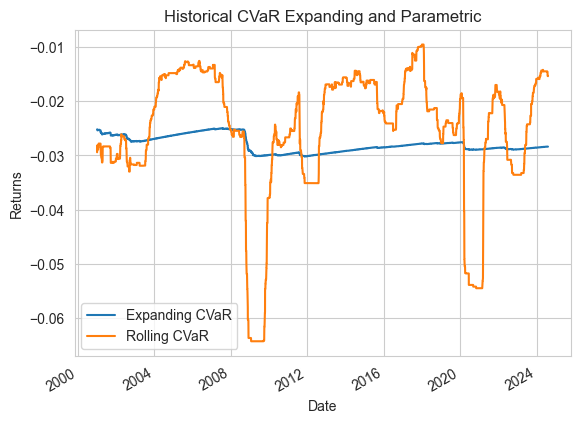

In [158]:
(
    spy_cvar_example
    .dropna()
    .loc["2001-01-01":]
    .plot(title="Historical CVaR Expanding and Parametric", xlabel="Date", ylabel="Returns")
);

<span style="color:blue;">

#### Parametric CVaR

Parametric CVaR for normal distribution is the expected value of the gaussian distribution between $-\infty$ and $r^{VaR}$:

\begin{align*}
\mathbb{E}[r | r < r^{VaR}] &= \dfrac{\int_{-\infty}^{0.05} r \phi(r) \, dx}{\int_{-\infty}^{0.05} \phi(r) \, dx} \\
                            &= \dfrac{\int_{-\infty}^{0.05} r \phi(r) \, dx}{\alpha}
\end{align*}

</span>

In [159]:
spy_var_cvar_stats = pmh.calc_var_cvar_summary(
    spy_excess_returns,
    window=252,
    drop_columns=["GARCH"],
    z_score=-1.65
)
spy_cvar = (
    spy_var_cvar_stats
    .loc[:, lambda df: df.columns[df.columns.map(lambda x: bool(re.search("CVaR", x)))]]
    .loc["2001-01-01":]
)
spy_cvar.tail()

VaR and CVaR are given shifted by 1.000000 period(s).


,Expanding 252 Historical CVaR (5.00%),Rolling 252 Historical CVaR (5.00%),Expanding 252 Parametrical CVaR (5.00%),Rolling 252 Parametrical CVaR (5.00%),EWMA 0.94 Parametrical CVaR (5.00%)
date,,,,,
2024-07-29,-0.0284,-0.0154,-0.0244,-0.0149,-0.0173
2024-07-30,-0.0284,-0.0154,-0.0244,-0.0149,-0.0168
2024-07-31,-0.0284,-0.0154,-0.0244,-0.0149,-0.0165
2024-08-01,-0.0284,-0.0154,-0.0244,-0.0150,-0.0179
2024-08-02,-0.0284,-0.0154,-0.0244,-0.0151,-0.0188


<Axes: title={'center': 'CVaR'}, xlabel='Date', ylabel='Returns'>

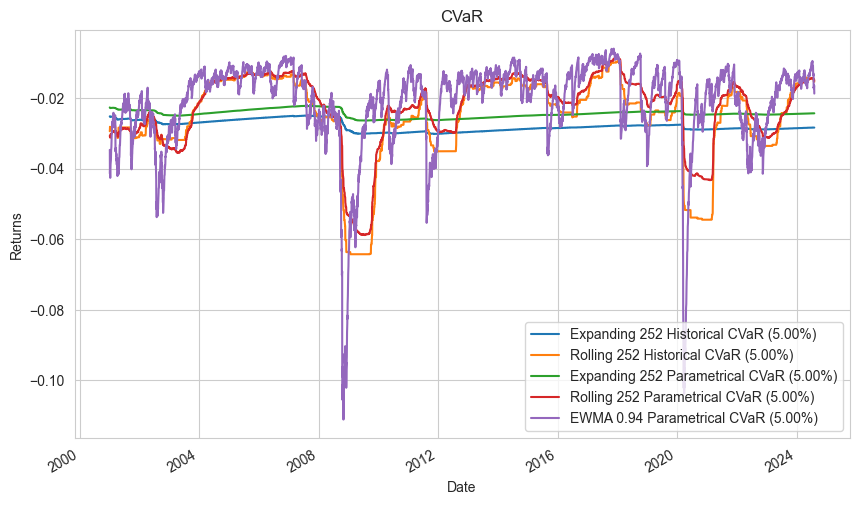

In [160]:
(
    spy_cvar
    .plot(title="CVaR", xlabel="Date", ylabel="Returns", figsize=(10, 6))
)

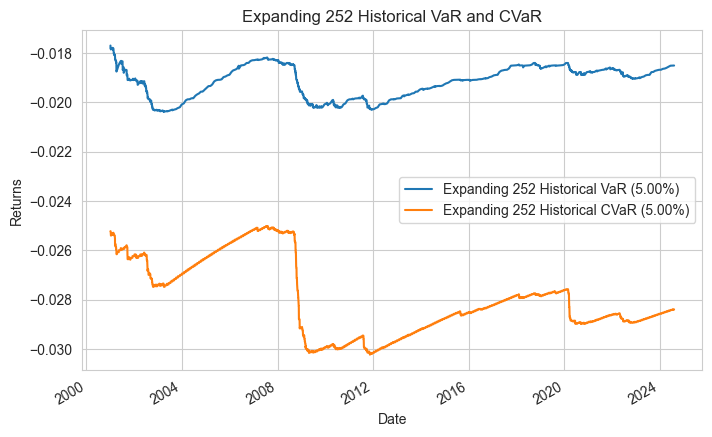

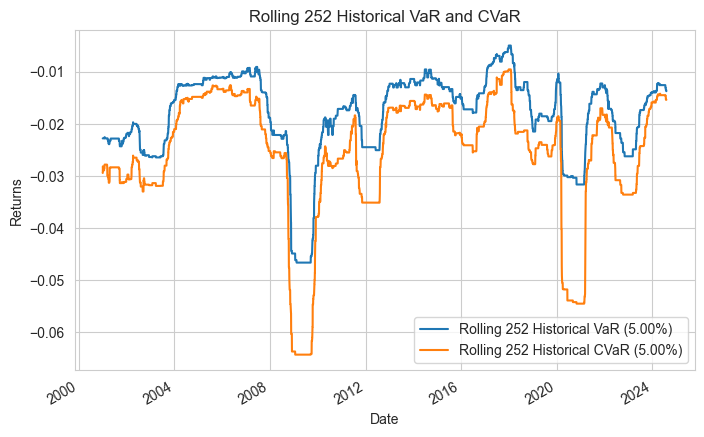

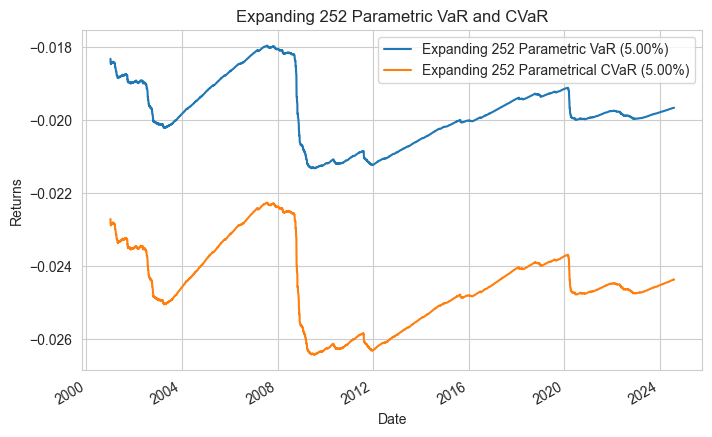

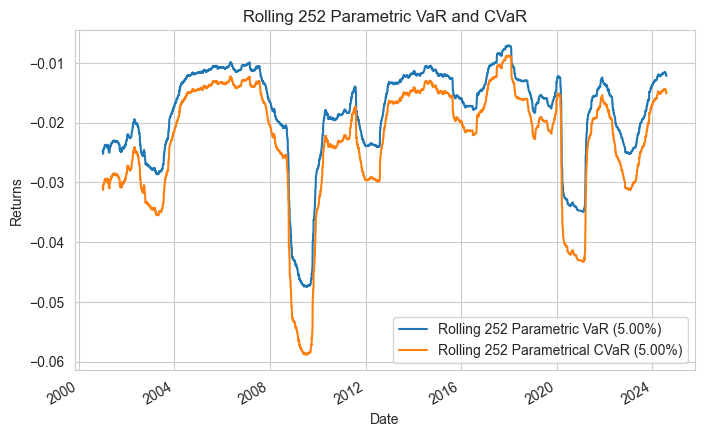

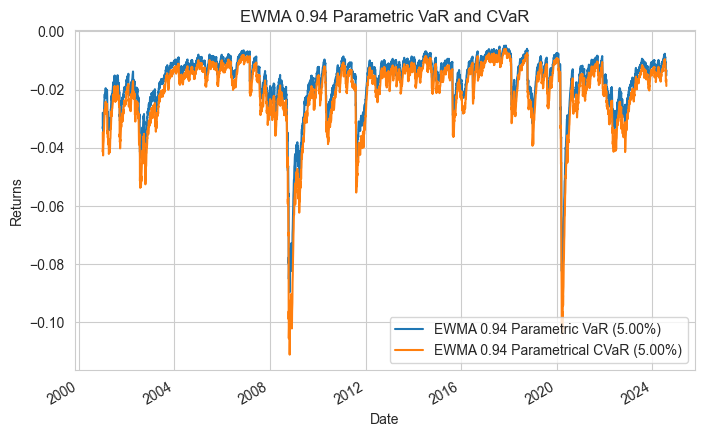

In [161]:
cvar_types = [
    'Expanding 252 Historical',
    'Rolling 252 Historical',
    'Expanding 252 Parametric',
    'Rolling 252 Parametric',
    'EWMA 0.94 Parametric'
]
for cvar_type in cvar_types:
    (
        spy_var_cvar_stats
        .loc[:, lambda df: df.columns[df.columns.map(lambda x: bool(re.search(cvar_type, x)))]]
        .loc[:, lambda df: df.columns[df.columns.map(lambda x: bool(re.search("VaR|CVaR", x)))]]
        .loc["2001-01-01":]
        .plot(title=f"{cvar_type} VaR and CVaR", xlabel="Date", ylabel="Returns", figsize=(8, 5))
    )

***

## 1.4 GARCH

#### EXTRA: Not Submitted, not covered in Midterm 1

Re-do the VaR and CVaR calculations using a normal model with volatility calculated from a GARCH(1,1).

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine. You should be familiar with EWMA and GARCH from the August Review.

In [162]:
def calc_garch_volatility(excess_returs: pd.Series, p: int = 1, q: int = 1):
    model = arch_model(excess_returs, vol='Garch', p=p, q=q)
    fitted_model = model.fit(disp='off')
    fitted_values = fitted_model.conditional_volatility
    return pd.Series(fitted_values, index=excess_returs.index)

In [163]:
calc_garch_volatility(spy_excess_returns["SPY"].shift().dropna())

/opt/homebrew/anaconda3/envs/finm/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


date
1994-01-05   0.0059
1994-01-06   0.0059
1994-01-07   0.0058
1994-01-10   0.0057
1994-01-11   0.0058
              ...  
2024-07-29   0.0104
2024-07-30   0.0105
2024-07-31   0.0100
2024-08-01   0.0097
2024-08-02   0.0104
Name: cond_vol, Length: 7679, dtype: float64

/opt/homebrew/anaconda3/envs/finm/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<Axes: title={'center': 'GARCH(1, 1) Annualized Volatility'}, xlabel='date'>

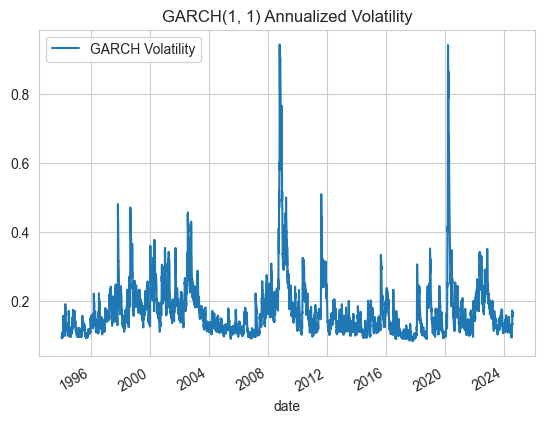

In [164]:
(
    calc_garch_volatility(spy_excess_returns["SPY"].shift().dropna())
    .map(lambda x: x * np.sqrt(252))
    .to_frame("GARCH Volatility")
    .plot(title="GARCH(1, 1) Annualized Volatility")
)

In [165]:
def calc_garch_var(
        excess_returs: pd.Series,
        p: int = 1,
        q: int = 1,
        quantile: float = .05,
        z_score: float = None
    ):
    fitted_values = calc_garch_volatility(excess_returs, p, q)
    if z_score is None:
        z_score = norm.ppf(quantile)
    return -abs(fitted_values * z_score)

/opt/homebrew/anaconda3/envs/finm/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


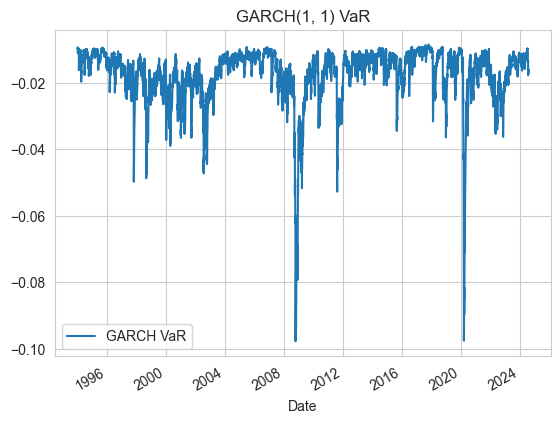

In [166]:
(
    calc_garch_var(spy_excess_returns["SPY"].shift().dropna())
    .to_frame("GARCH VaR")
    .plot(title="GARCH(1, 1) VaR", xlabel="Date")
);

In [167]:
spx_garch_var_cvar = pmh.calc_var_cvar_summary(
    spy_excess_returns,
    keep_columns=["GARCH"],
    window=60,
    z_score=-1.65
)
spx_garch_var_cvar

VaR and CVaR are given shifted by 1.000000 period(s).


,"GARCH(1, 1) Volatility","GARCH(1, 1) Parametric VaR (5.00%)","GARCH(1, 1) Parametrical CVaR (5.00%)"
date,,,
1994-01-04,NaN,NaN,NaN
1994-01-05,0.0059,-0.0098,-0.0121
1994-01-06,0.0059,-0.0097,-0.0120
1994-01-07,0.0058,-0.0096,-0.0118
1994-01-10,0.0057,-0.0094,-0.0116
...,...,...,...
2024-07-29,0.0104,-0.0172,-0.0214
2024-07-30,0.0105,-0.0173,-0.0214
2024-07-31,0.0100,-0.0164,-0.0204


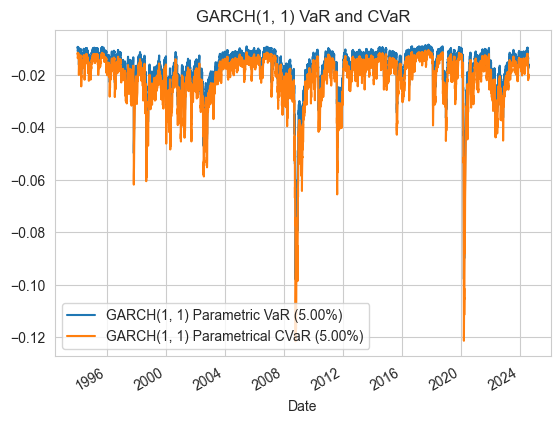

In [168]:
(
    spx_garch_var_cvar
    .drop("GARCH(1, 1) Volatility", axis=1)
    .plot(title="GARCH(1, 1) VaR and CVaR", xlabel="Date")
);

VaR and CVaR are given shifted by 1.000000 period(s).


<Axes: title={'center': 'GARCH and Other VaR'}, xlabel='Date'>

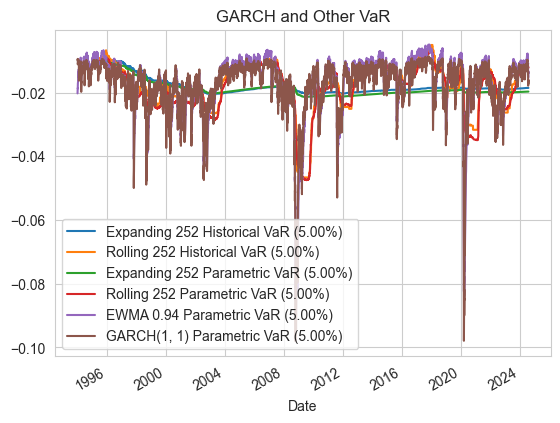

In [169]:
spx_var = pmh.calc_var_cvar_summary(
    spy_excess_returns,
    keep_columns=["VaR"],
    drop_columns=["CVaR"],
    window=252,
    z_score=-1.65
)
(
    spx_var
    .plot(title="GARCH and Other VaR", xlabel="Date")
)

In [170]:
pmh.calc_var_cvar_summary(
    spy_excess_returns,
    return_hit_ratio=True,
    filter_first_hit_ratio_date="2001-01-01",
    window=252,
    z_score=-1.65
)

,Hit Ratio,Hit Ratio Error,Hit Ratio Absolute Error
"GARCH(1, 1) Parametric VaR (5.00%)",0.0501,0.0022,0.0022
Expanding 252 Historical VaR (5.00%),0.0486,-0.0282,0.0282
Rolling 252 Parametric VaR (5.00%),0.0528,0.0562,0.0562
Rolling 252 Historical VaR (5.00%),0.0530,0.0596,0.0596
Expanding 252 Parametric VaR (5.00%),0.0461,-0.0788,0.0788
EWMA 0.94 Parametric VaR (5.00%),0.0599,0.1979,0.1979
